In [26]:
#Pytket imports
from pytket import Circuit, OpType
from pytket.circuit import CircBox
from pytket.utils import compare_unitaries

#My imports
from qft_setup import build_inverse_qft
from utils_checks import qft_unitary_dag


In [3]:
anc_qubits=5 # How many qubits are we going to use to estimate the phase?
phase_input=4/5 # Our phase we want to estimate

shots=1000 # How many shots in our experiment?

In [4]:
# Check that inverse QFT is implemented correctly
compare_unitaries(build_inverse_qft(3).get_unitary(), qft_unitary_dag(3)) 

True

In [5]:
inv_qft_box = CircBox(build_inverse_qft(anc_qubits))

In [6]:
def build_phase_est_circ(n_ancillas,test_phase, state = Circuit(1)):#here state= Circuit(1) for sq gates
    """Constructs a phase estimation circuit to estimate the phase applied on
    qubit n+1 using n qubits"""
    
    phase_circ = Circuit(n_ancillas+len(state.qubits),n_ancillas)
    
    phase_circ.X(n_ancillas)
    
    for j in range(n_ancillas):
        phase_circ.H(j)
        
    for k in range(n_ancillas):
        for l in range(2**k):
            phase_circ.add_gate(OpType.CU1,test_phase,[n_ancillas - 1 - k, n_ancillas])
                                 
    # Append inverse qft as gates
    #phase_circ.append(build_inverse_qft(n_ancillas)) 
    
     # Append inverse qft as a box
    phase_circ.add_circbox(inv_qft_box, [x for x in range(n_ancillas)] ,opgroup = "Inverse QFT")
    
    
    for m in range(n_ancillas):
        phase_circ.Measure(m,m)
        
    return phase_circ


In [7]:
from pytket.circuit.display import render_circuit_jupyter

est_phase = build_phase_est_circ(anc_qubits , phase_input)


#render_circuit_jupyter(est_phase) # draw our phase estimation circuit

In [8]:
from pytket.passes import DecomposeBoxes
DecomposeBoxes().apply(est_phase) # Decompose the inverse QFT Box structure

#render_circuit_jupyter(est_phase)

True

In [22]:
from pytket.extensions.qiskit import IBMQEmulatorBackend

guadalupe_backend = IBMQEmulatorBackend('ibmq_guadalupe', hub ='partner-cqc', group ='internal', project ='default')
compiled_circ = guadalupe_backend.get_compiled_circuit(est_phase)

#render_circuit_jupyter(compiled_circ)
print("Number of gates in Circuit: ", compiled_circ.n_gates)
print("Number of CX gates in Circuit: ", compiled_circ.n_gates_of_type(OpType.CX))

Number of gates in Circuit:  245
Number of CX gates in Circuit:  118


In [23]:
handle = guadalupe_backend.process_circuit(compiled_circ, shots)
my_result = guadalupe_backend.get_result(handle)
#my_result.get_counts() 

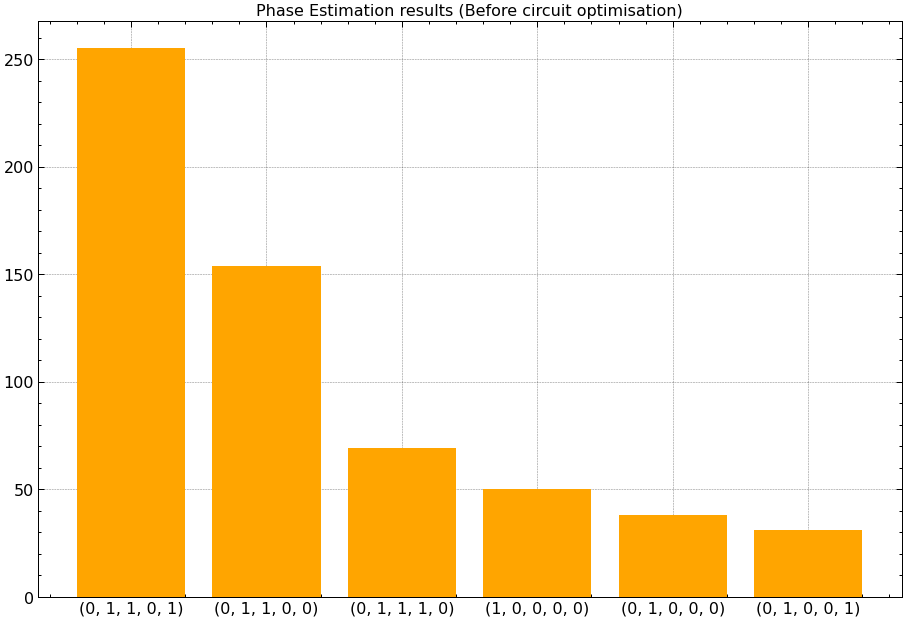

In [11]:
from plotting import plot_results

rank_number = 7 # Choose the number of basis states to include in the plot. For n_qubits there could be 2**n

plot_results(my_result, rank = rank_number, title = 'Phase Estimation results (Before circuit optimisation)')

In [12]:
from pytket.passes import (
    SequencePass,
    RebaseCustom,
    CXMappingPass,
    FullPeepholeOptimise,
    RemoveRedundancies,
)

from pytket.placement import NoiseAwarePlacement

guadalupe_info = guadalupe_backend.backend_info
guadalupe_placer = NoiseAwarePlacement(arc = guadalupe_info.architecture,
                                       node_errors = guadalupe_info.averaged_node_gate_errors,
                                       link_errors = guadalupe_info.averaged_edge_gate_errors,
                                       readout_errors = guadalupe_info.averaged_readout_errors)


guadalupe_mapping_pass = CXMappingPass(
    guadalupe_info.architecture,
    guadalupe_placer,
    directed_cx = False
)

from pytket.passes import auto_rebase_pass

ibm_rebase = auto_rebase_pass({OpType.CX, OpType.X, OpType.SX, OpType.Rz})

In [24]:
sequence_pass = SequencePass([FullPeepholeOptimise(), guadalupe_mapping_pass, ibm_rebase, RemoveRedundancies()])
sequence_pass.apply(compiled_circ)

#guadalupe_backend.default_compilation_pass(2).apply(compiled_circ)

print("Number of gates in Circuit: ", compiled_circ.n_gates)
print("Number of CX gates in Circuit: ", compiled_circ.n_gates_of_type(OpType.CX))

#render_circuit_jupyter(compiled_circ)

Number of gates in Circuit:  172
Number of CX gates in Circuit:  60


In [25]:
handle = guadalupe_backend.process_circuit(compiled_circ, shots)
my_result_opt=guadalupe_backend.get_result(handle)
#my_result_opt.get_counts() # Display counts for optimised circuit

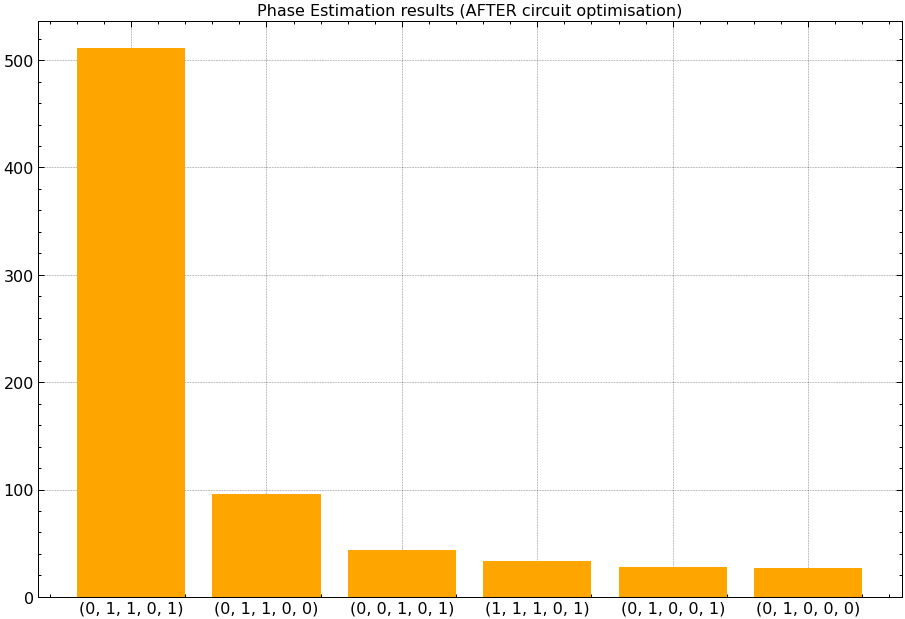

In [15]:
plot_results(my_result_opt, rank = rank_number , title = 'Phase Estimation results (AFTER circuit optimisation)')

In [16]:
# Most probable basis state result as a tuple
max_key = max(my_result_opt.get_counts(), key = my_result_opt.get_counts().get)

# Convert this tuple to a string
def tuple_to_string2(tup): 
    """
    Converts a tuple to a string as follows (1,0,0) -> '100'
    """
    mystring = ''
    for entry in tup :
        mystring += str(entry)
        
    return mystring

highest_probability_string = tuple_to_string(max_key)

decimal_output = int(highest_probability_string,2) # Convert from binary string to a decimal
        
phase_estimate = decimal_output/(2**anc_qubits)

naive_error = round(abs(phase_estimate-phase_input/2),4)

def percentage_error(error):
    """
    Returns the naive error percentage bewteen the input phase and the measured phase.
    """
    percentage = round( 2*error/phase_input *100, 1 ) #percentage error rounded to 1dp
    print( "Naive error percentage = {}%".format(percentage))

In [17]:
# Our "winning" basis state
highest_probability_string

'01101'

In [18]:
decimal_output # Divide this by 2**anc_qubits to get phase

13

In [19]:
# This is our phase estimate... Ideally it should equal phase_input/2
phase_estimate

0.40625

In [20]:
# Expected answer
phase_input/2

0.4

In [21]:
naive_error # How much did we miss our expected result by? absolute value to 4dp

0.0062

In [21]:
percentage_error(naive_error) # percentage erroe to 1dp

Naive error percentage = 1.5%
